In [15]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.centrality as centrality

In [16]:
def get_value(name, maps):
    for nodes in maps:
        if nodes["name"] == name:
            return nodes["value"]

def get_info(data):
    connections = defaultdict(int)
    interactions = defaultdict(int)
    for link in data["links"]:
        connections[data["nodes"][link["source"]]["name"]] += 1
        connections[data["nodes"][link["target"]]["name"]] += 1
        interactions[data["nodes"][link["source"]]["name"]] += link["value"]
        interactions[data["nodes"][link["target"]]["name"]] += link["value"]
    return connections, interactions
   
def get_betweenness(data):
    nodes = [ node['name'] for node in data["nodes"] ]
    edges = [ (nodes[link['source']], nodes[link['target']]) for link in data["links"] ]
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0],edge[1])
    plt.figure(figsize=(30,15))
    plt.subplot(121)
    nx.draw(G, with_labels=True)
    return sorted(centrality.betweenness_centrality(G).items(), key = lambda x: x[1])[::-1]

In [17]:
def get_homophily(data, characters):
    sides = []
    for side in characters.values():
        arr = []
        for count in range(len(data["nodes"])):
            if data["nodes"][count]["name"] in side:
                arr.append(count)
        sides.append(arr)
    
    homophily = []
    for side in sides:
        interacts = defaultdict(int)
        for link in data["links"]:
            if link["source"] in side:
                interacts[data["nodes"][link["target"]]["name"]] += link["value"]
                interacts[data["nodes"][link["source"]]["name"]] += link["value"]
            elif link["target"] in side:
                interacts[data["nodes"][link["source"]]["name"]] += link["value"]
                interacts[data["nodes"][link["target"]]["name"]] += link["value"]
        homophily.append(sorted(interacts.items(), key = lambda x: x[1])[::-1][:10])
    return homophily
                
def light_dark_classification(data, sides):
    light_side = []
    dark_side = []
    for i,j in sides.items():
        if j == '1':
            light_side.append(i)
        else:
            dark_side.append(i)
    
    sides = []
    for side in [light_side, dark_side]:
        arr = []
        for count in range(len(data["nodes"])):
            if data["nodes"][count]["name"] in side:
                arr.append(count)
        sides.append(arr)

    good = defaultdict(int)
    bad = defaultdict(int)
    for character in sides[0]:
        for link in data["links"]:
            if (link["source"] == character and link["target"] in sides[0]) or (link["target"] == character and link["source"] in sides[0]):
                good[data["nodes"][character]["name"]] += link["value"]/len(sides[0])  
            elif (link["source"] == character and link["target"] in sides[1]) or (link["target"] == character and link["source"] in sides[1]):
                bad[data["nodes"][character]["name"]] += link["value"]/len(sides[1])

    for elem in good.keys():
        if elem not in bad.keys():
            bad[elem] = 0

    for elem in bad.keys():
        if elem not in good.keys():
            good[elem] = 0

    correct = 0
    incorrect = 0
    for l, d in zip(sorted(good.items()), sorted(bad.items())):
        if l[1] >= d[1]:
            if l[0] in light_side:
                correct += 1
            else:
                incorrect += 1
        else:
            if d[0] in dark_side:
                correct += 1
            else:
                incorrect += 1

    return (correct, incorrect)

In [18]:
def loop(episode, feature, betweenness, degree_centrality):
    with open(f'data/starwars-episode-{episode}-{feature}.json') as f:
        data = json.load(f)
    connections, interractions = get_info(data)
    
#     Task 2 Hypothesis 1
    characters = {
        "Light Side": ["FINN", "OBI-WAN", "YODA", "PADME", "LUKE"], 
        "Dark Side": ["EMPEROR","DARTH VADER", "PIETT", "GENERAL HUX", "NUTE GUNRAY"]
    }    
    homophily = get_homophily(data, characters)
    
    with open('myfile.json') as d:
        sides = json.load(d)

    classification = light_dark_classification(data, sides)
    
#     Task 4
    temp = set()
    for i,j in zip(connections.items(), interractions.items()):
        temp.add((i[0], i[1], j[1], get_value(i[0], data["nodes"])))
    temp = sorted(temp, key = lambda x: x[1])[::-1]
    plt.figure(figsize=(25,10))
    plt.title(f'Episode-{episode} {feature}')
    plt.plot(list(zip(*temp))[0], list(zip(*temp))[1], list(zip(*temp))[0], list(zip(*temp))[2], list(zip(*temp))[0], list(zip(*temp))[3])
    plt.xticks(list(zip(*temp))[0][::1],  rotation='vertical')
#     plt.savefig(f'Episode_{episode}_{feature}.png')
    plt.show()

#     Task 2 Hypothesis 2
    if feature == "interactions-allCharacters":
        degree_centrality.append(sorted(connections.items(), key = lambda x: x[1])[::-1][:5])
        betweenness.append(get_betweenness(data)[:5])
    return betweenness, degree_centrality, homophily, classification

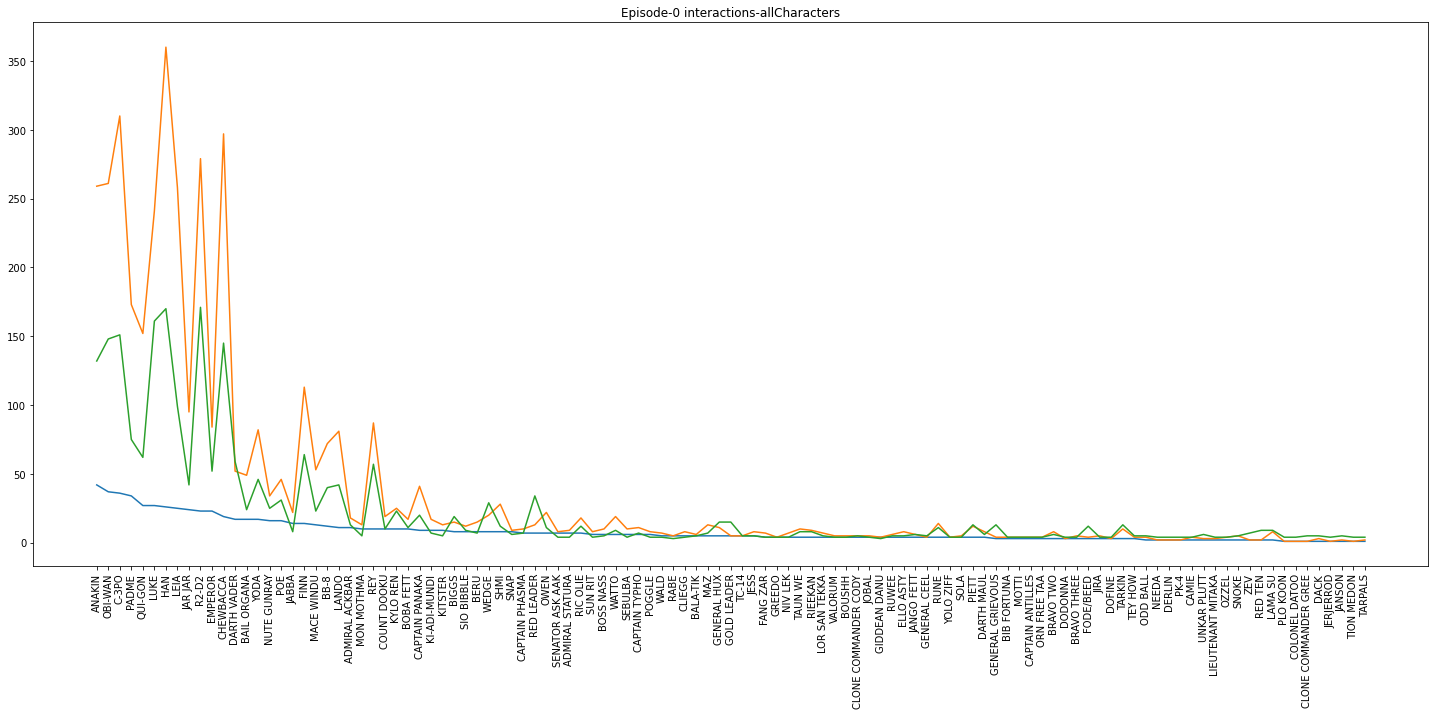

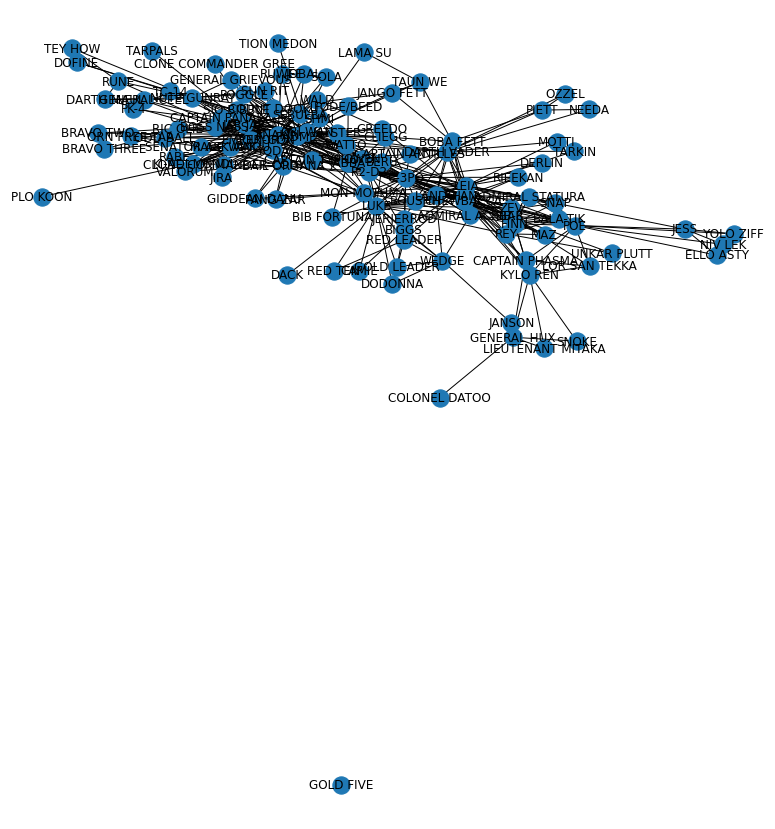

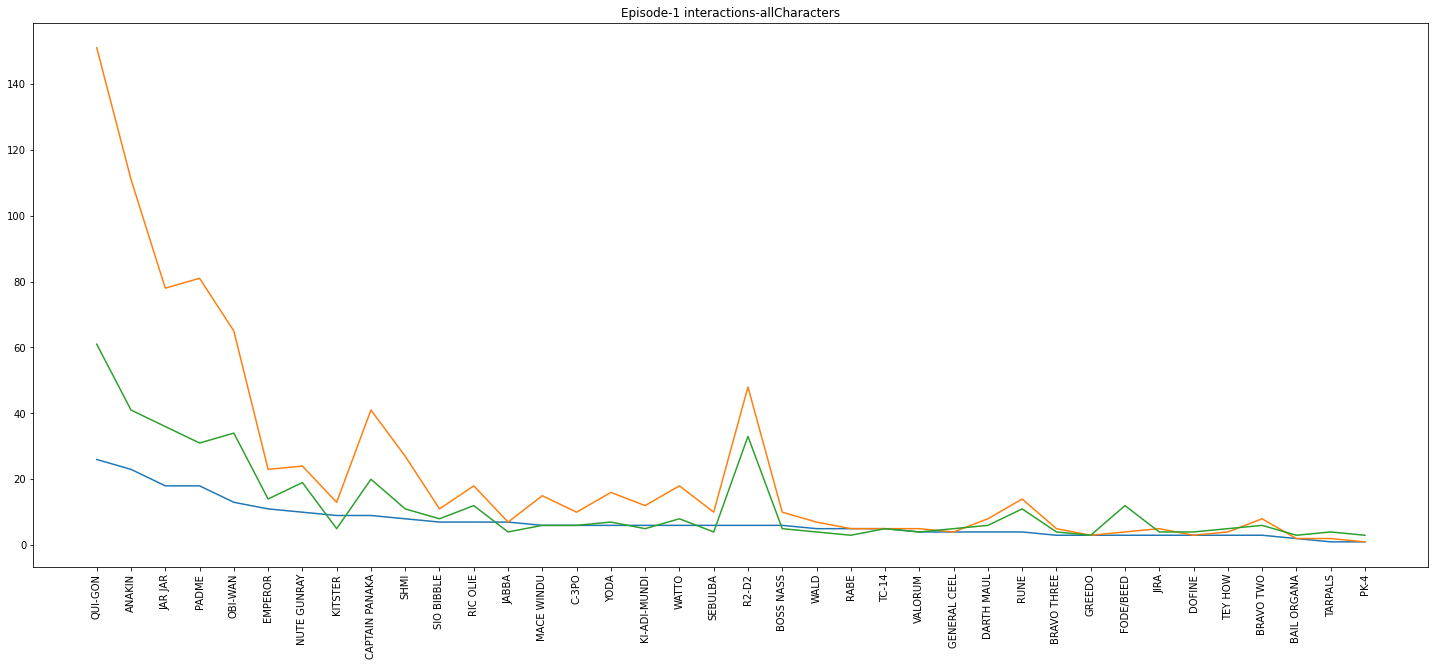

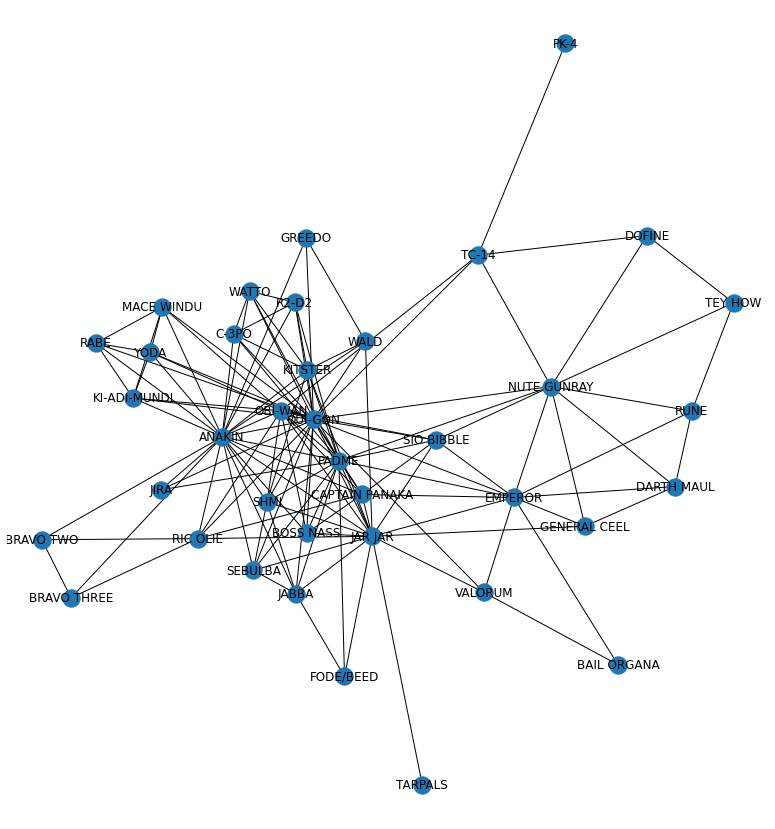

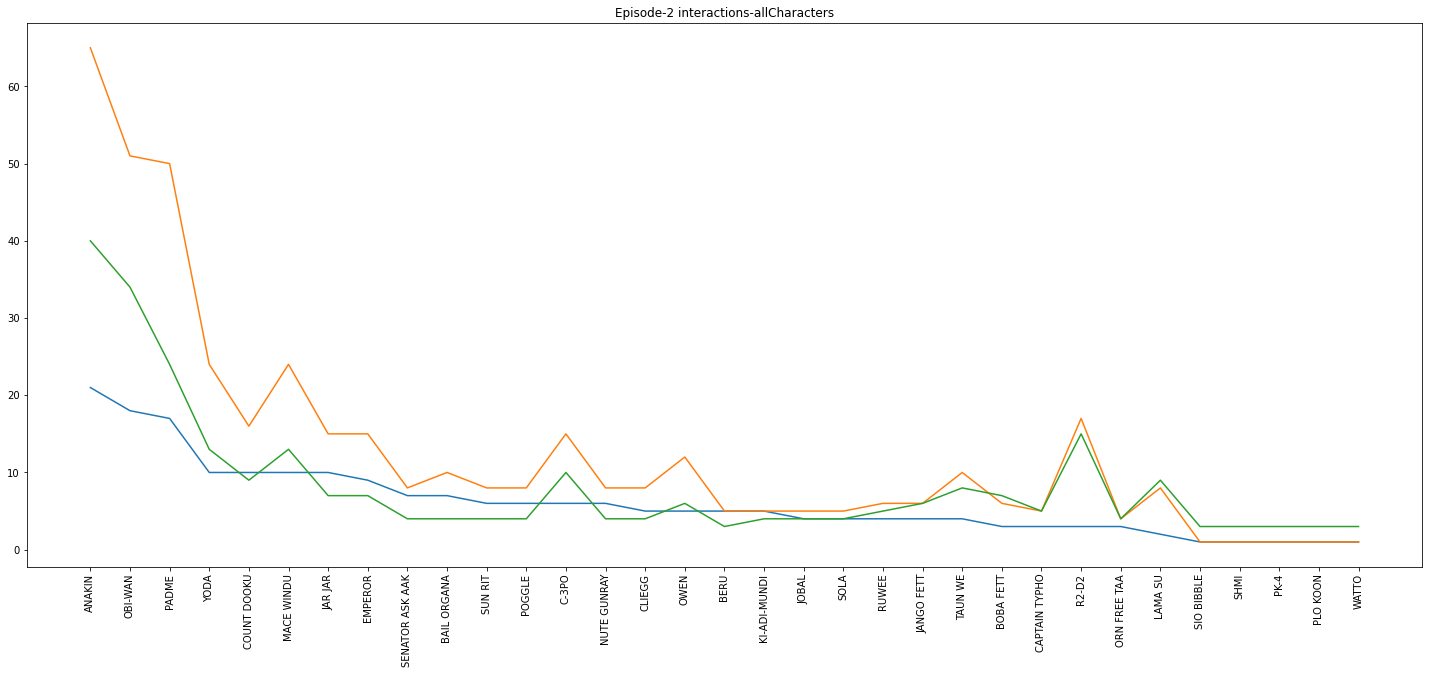

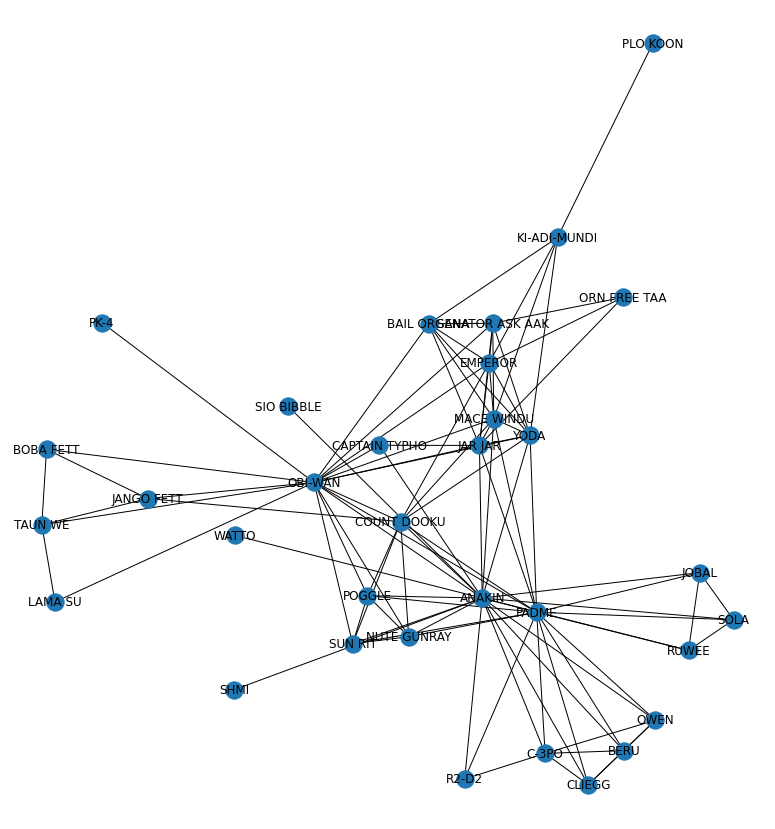

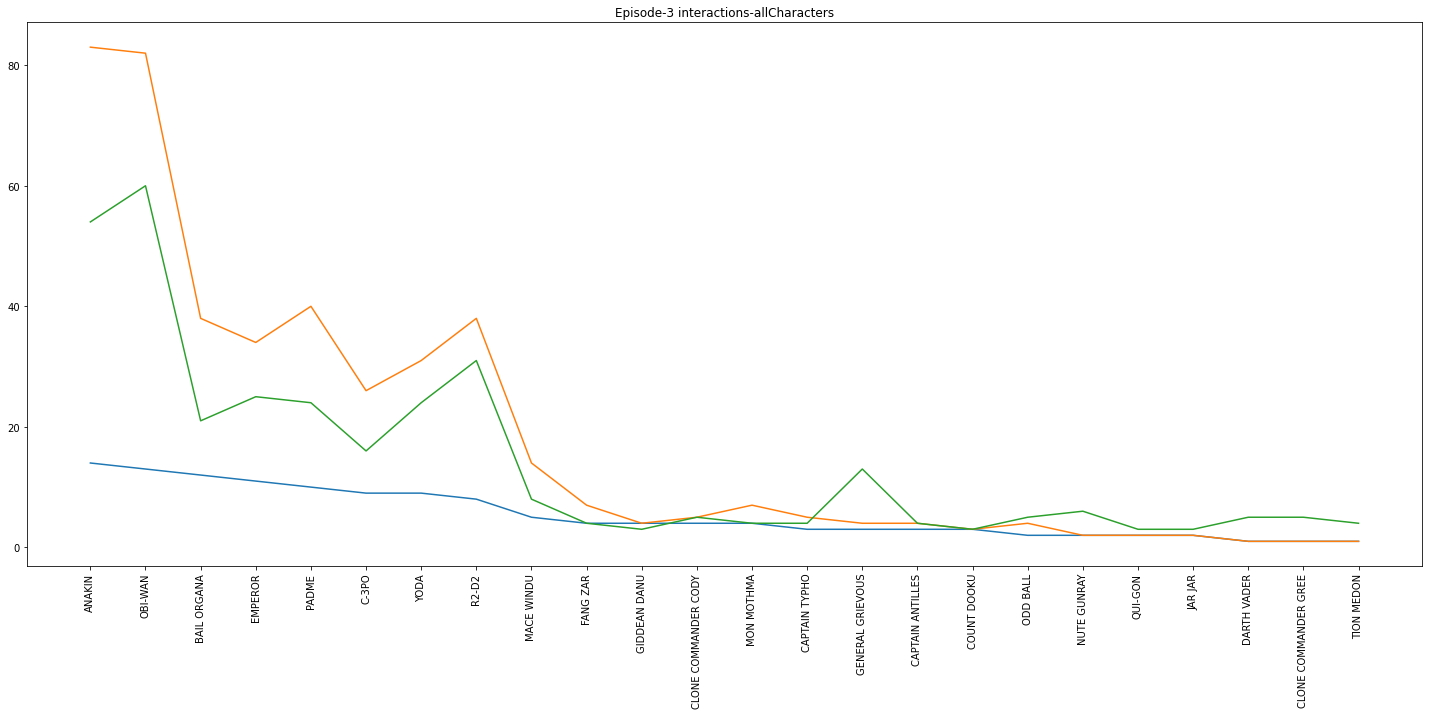

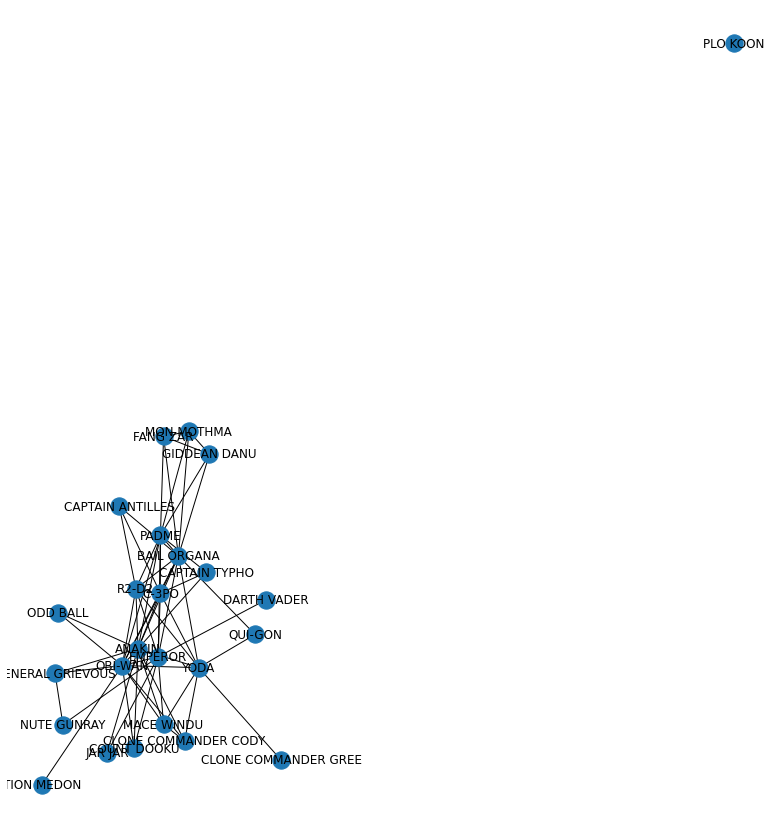

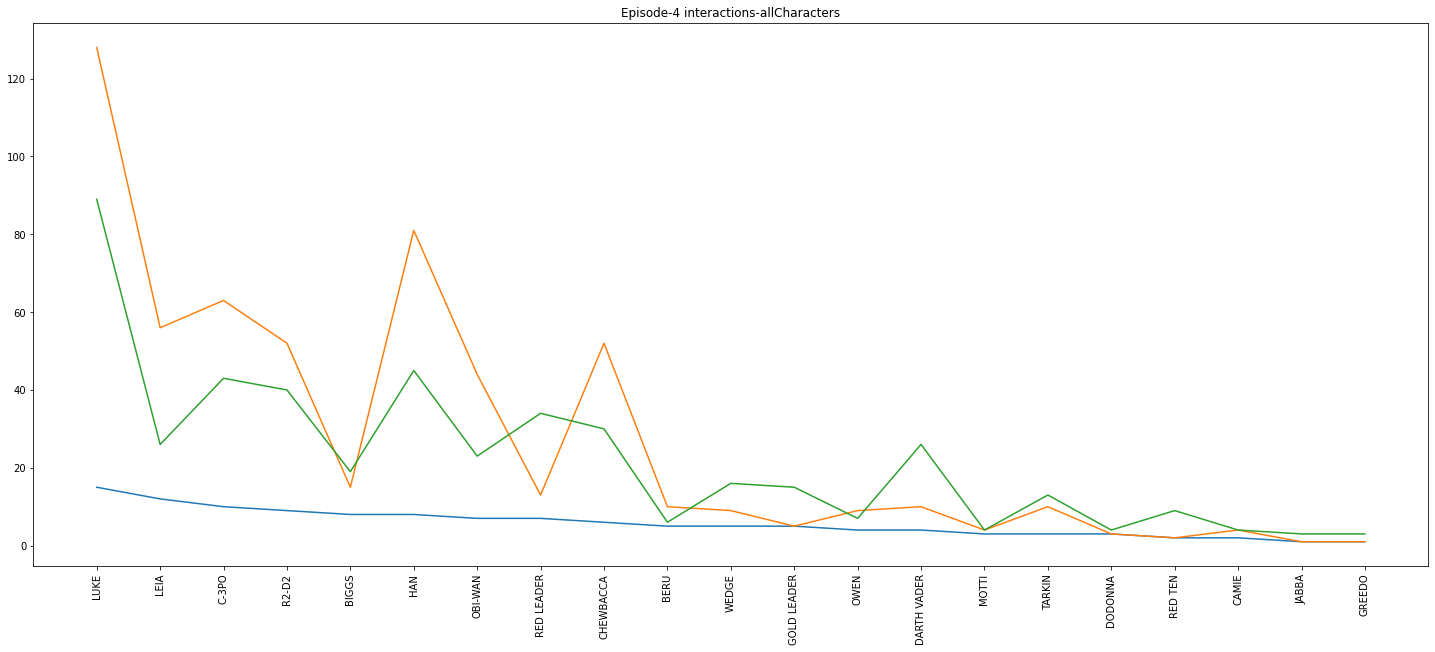

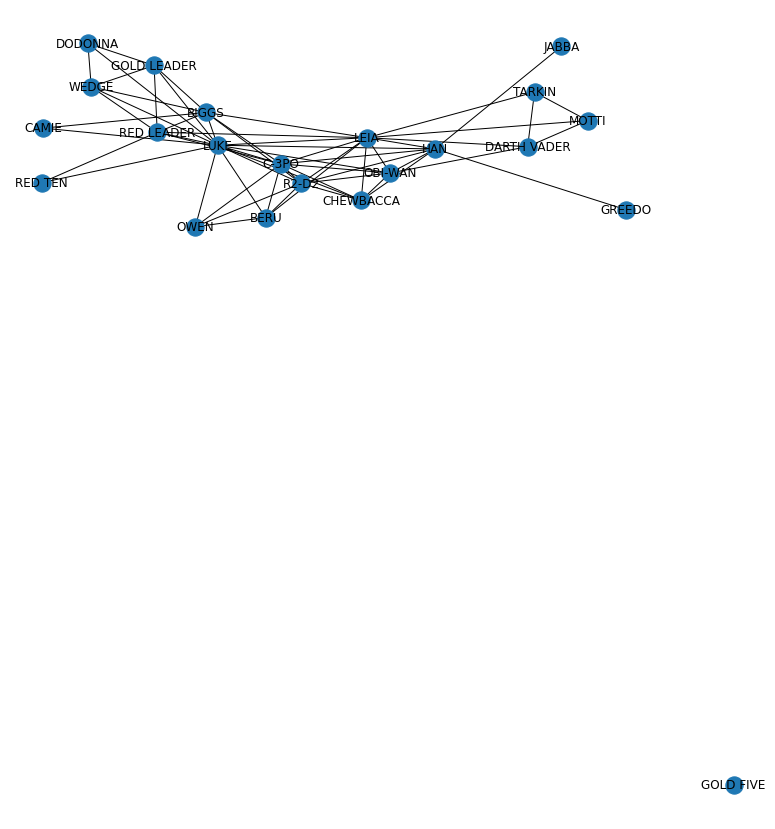

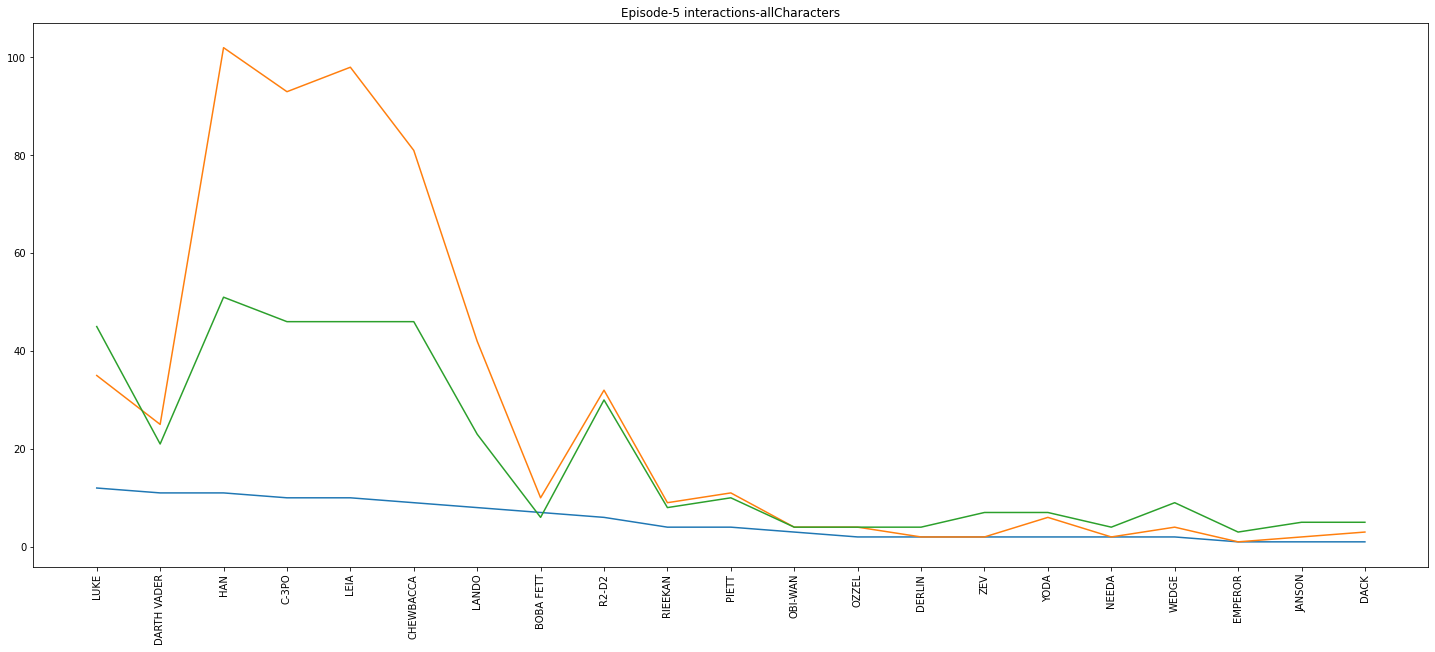

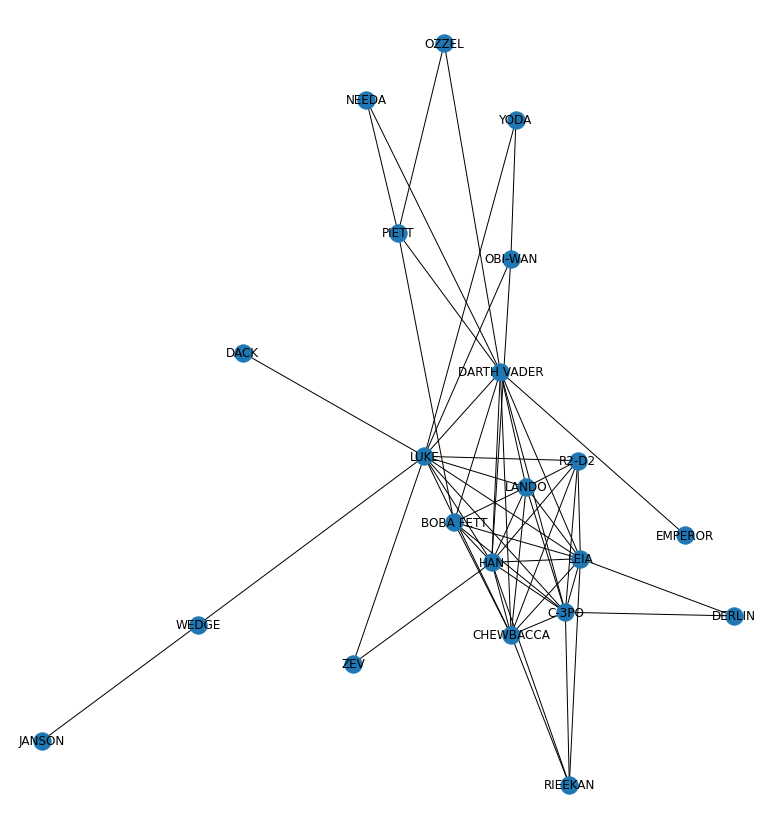

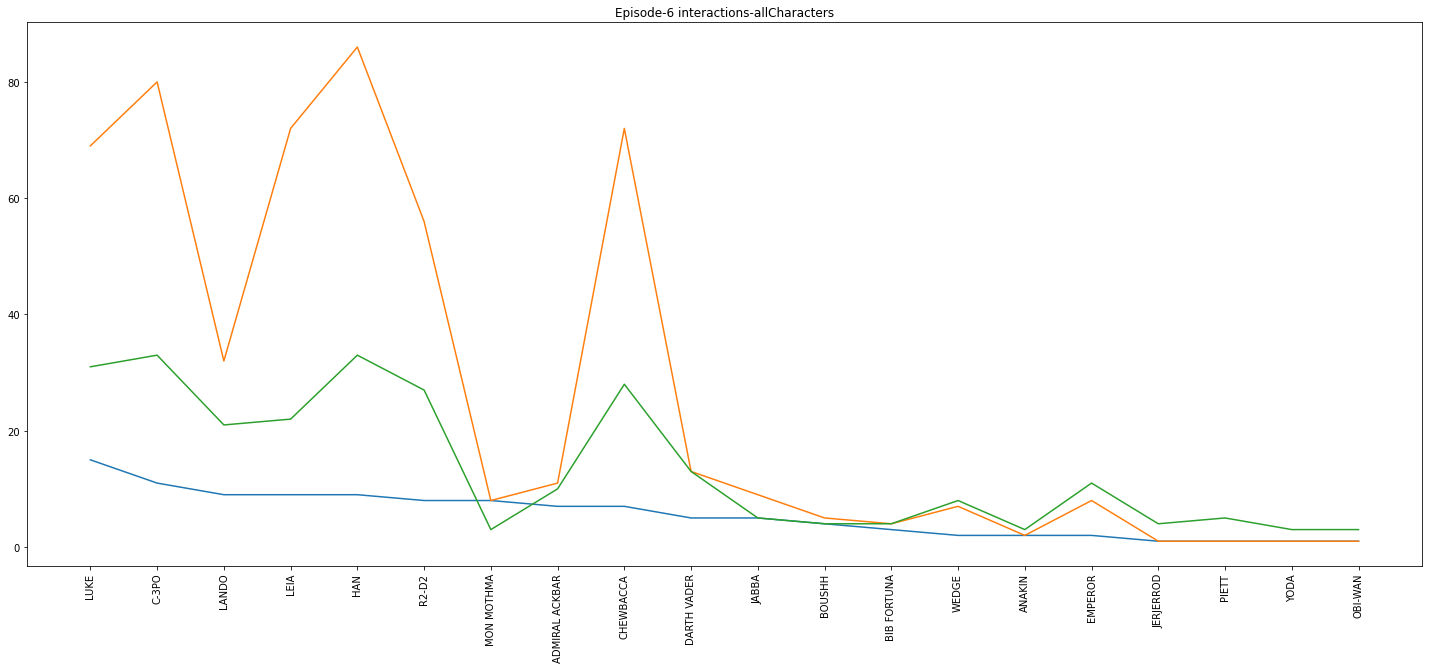

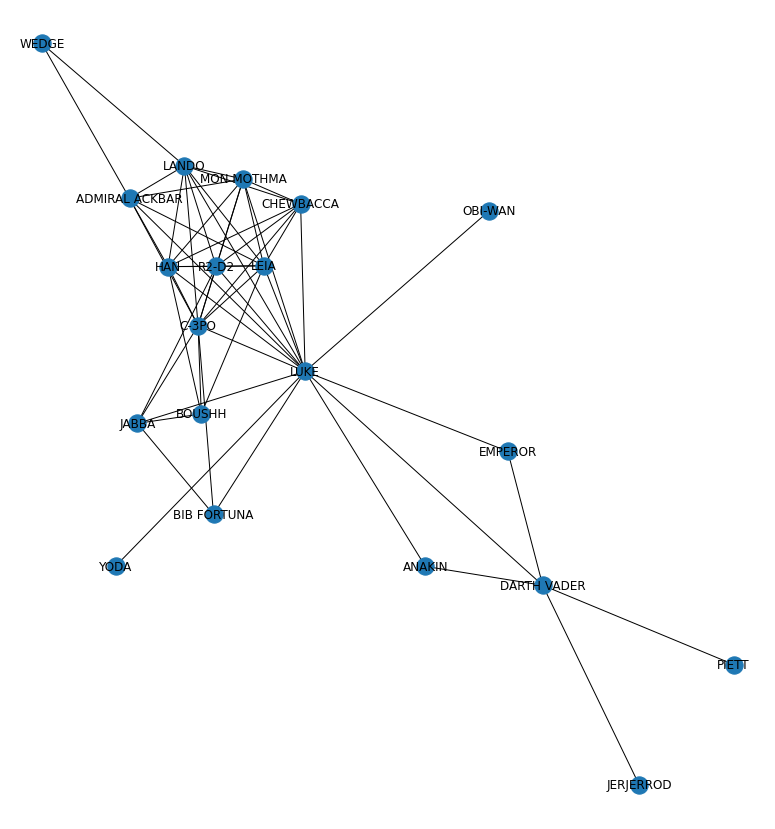

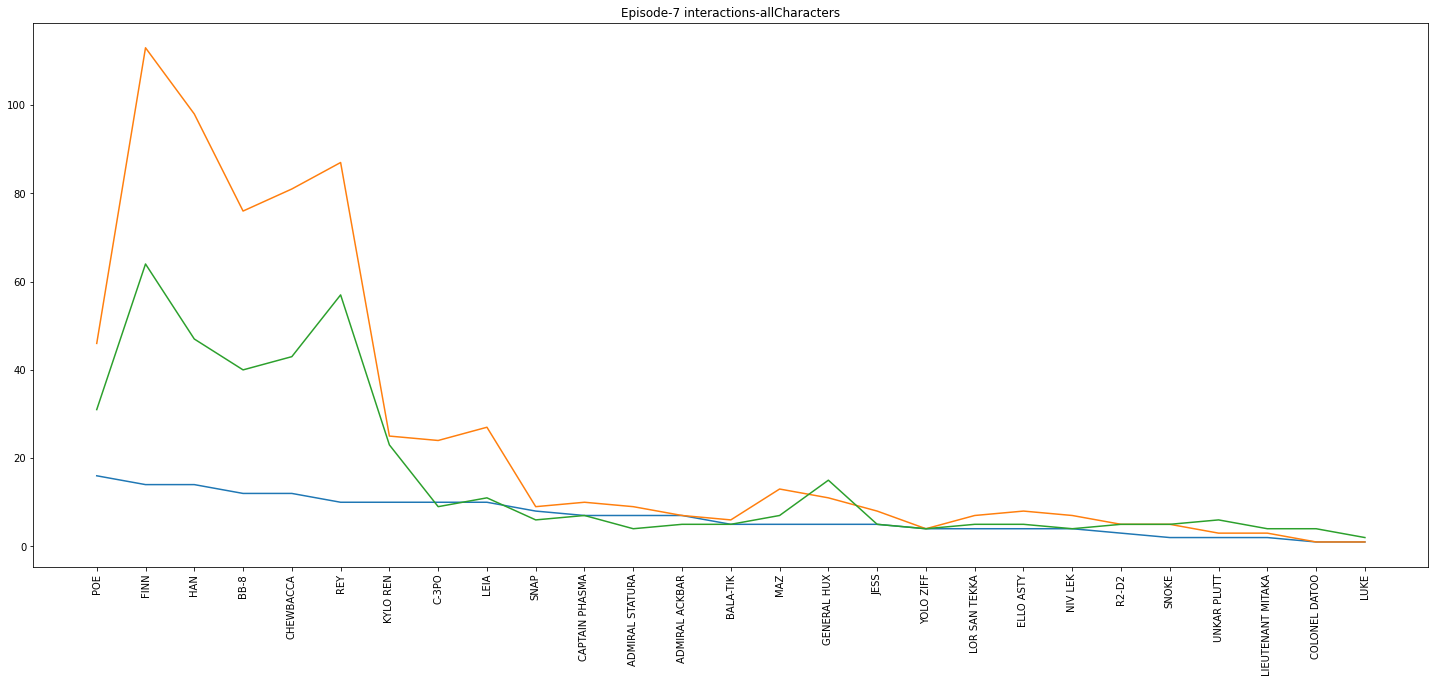

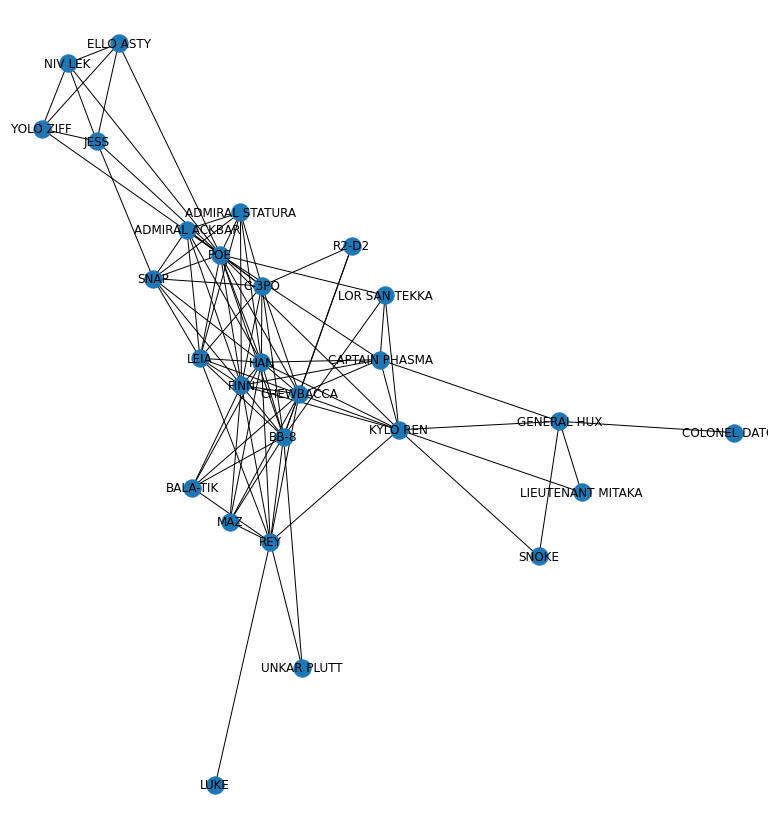

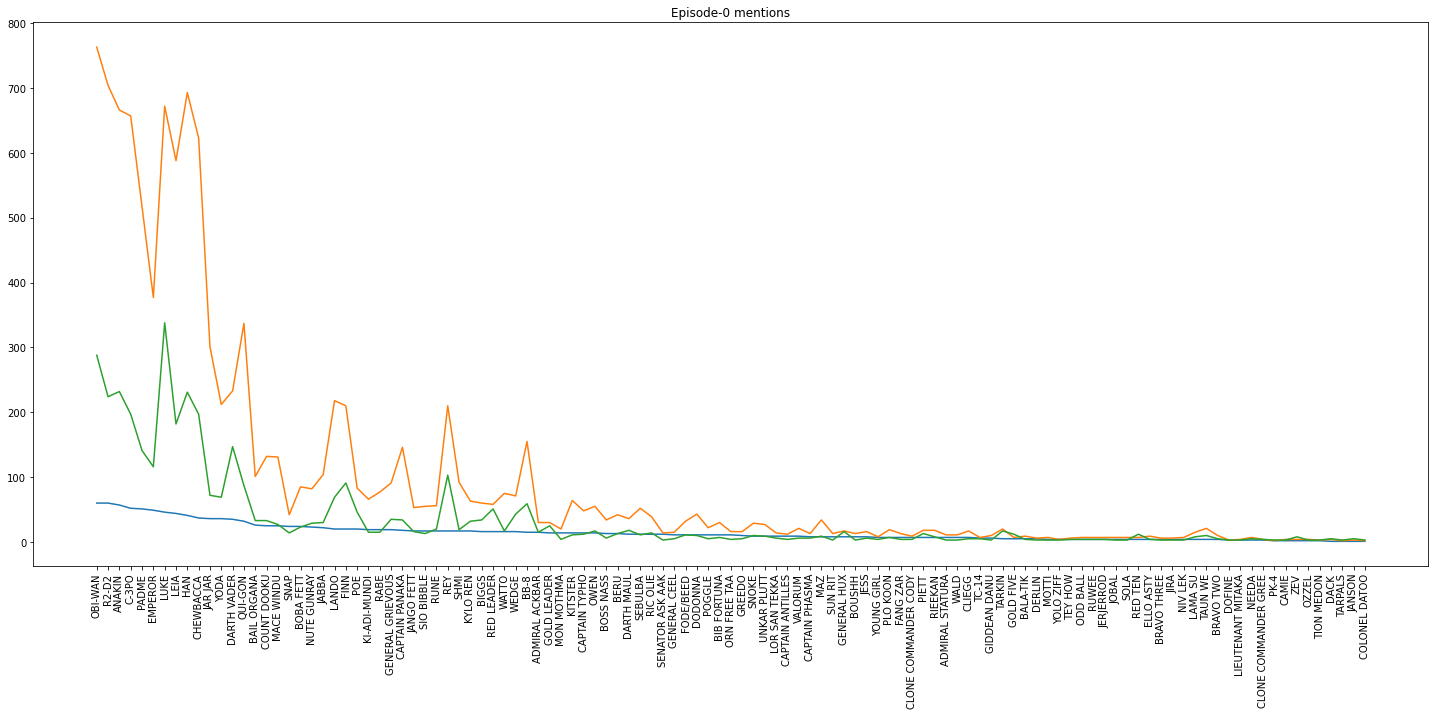

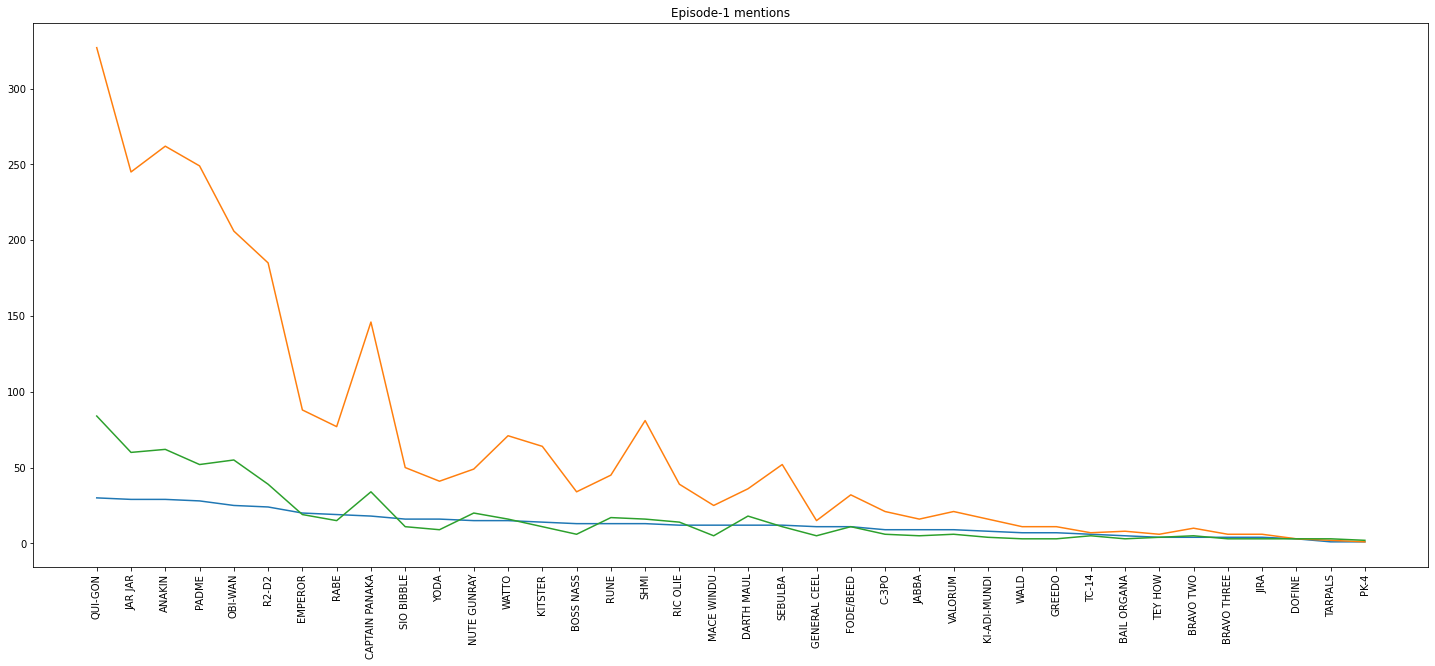

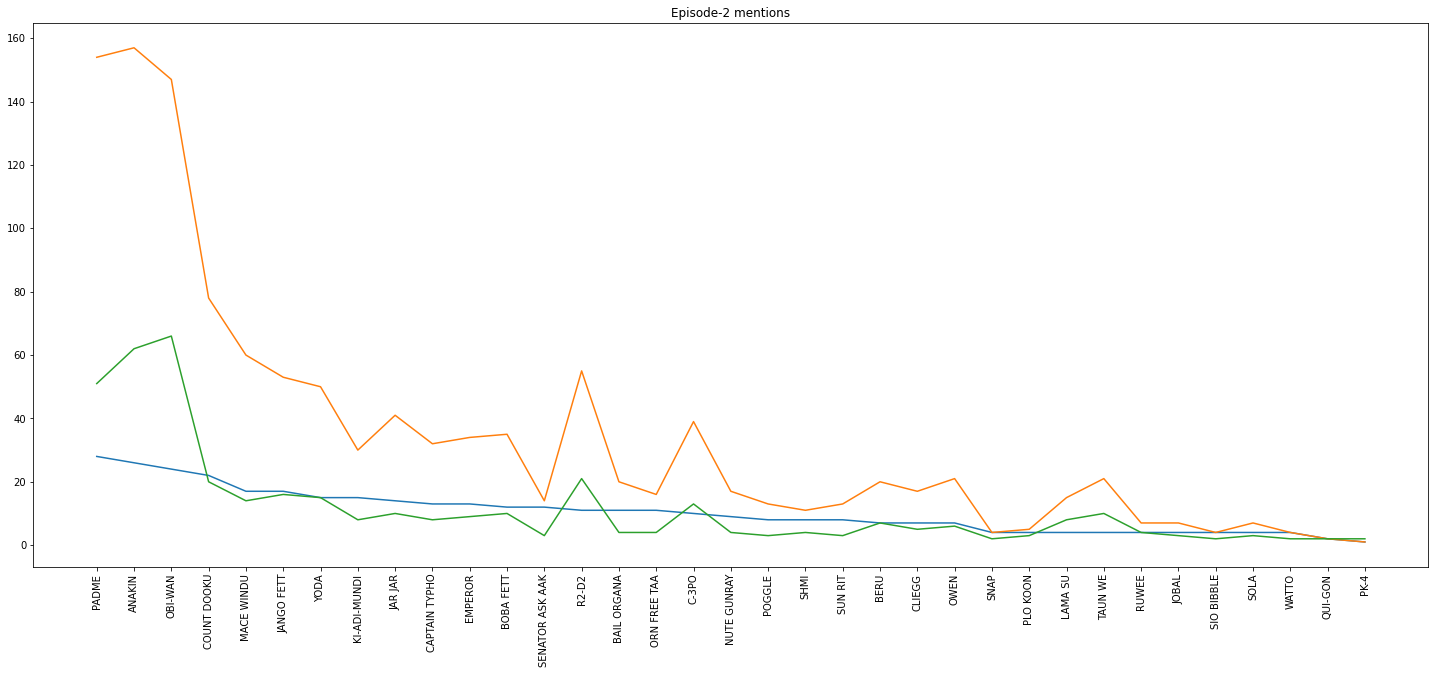

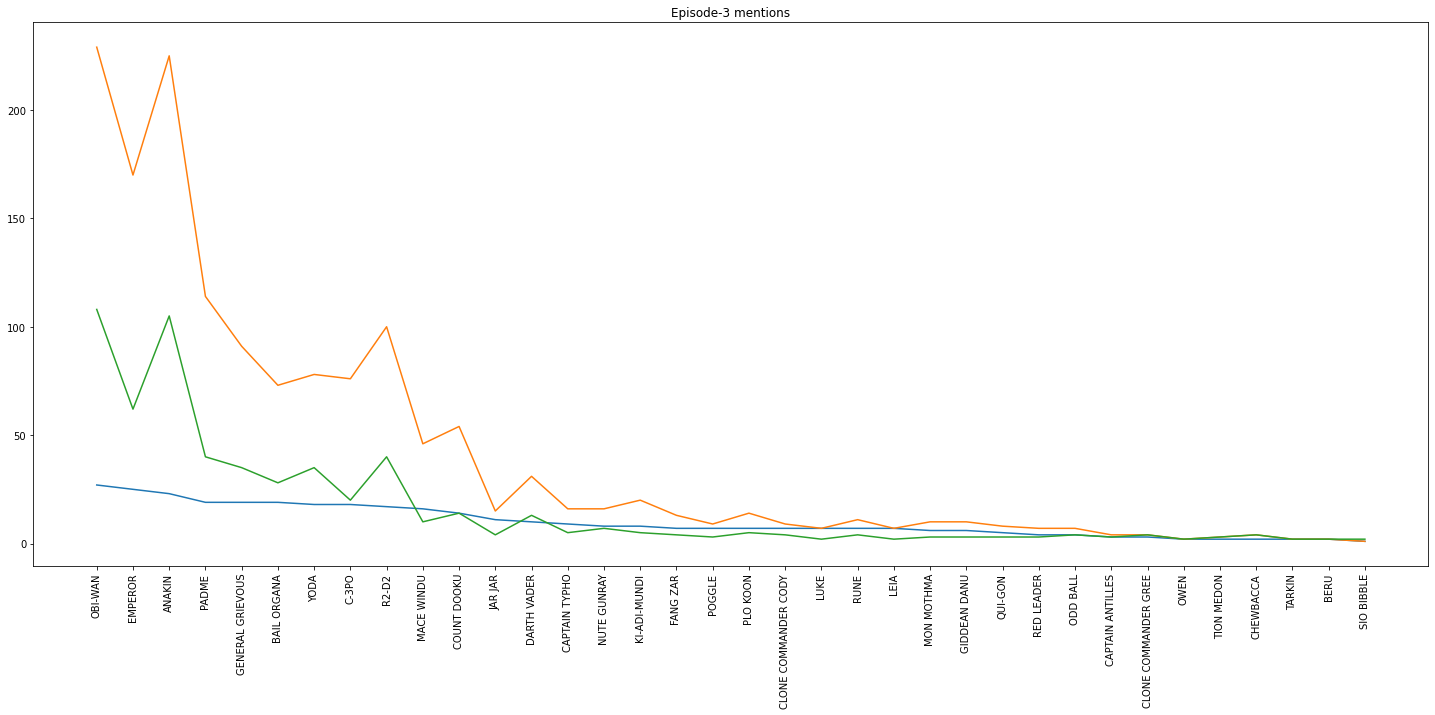

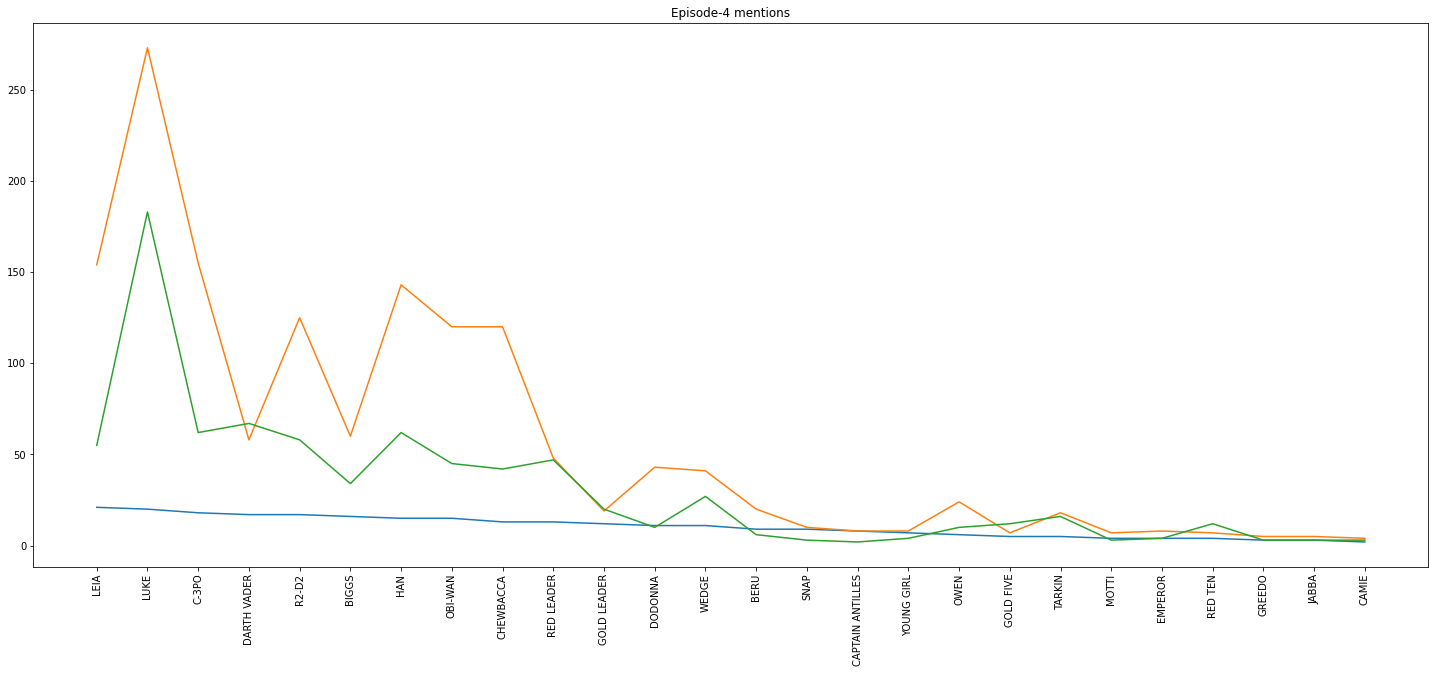

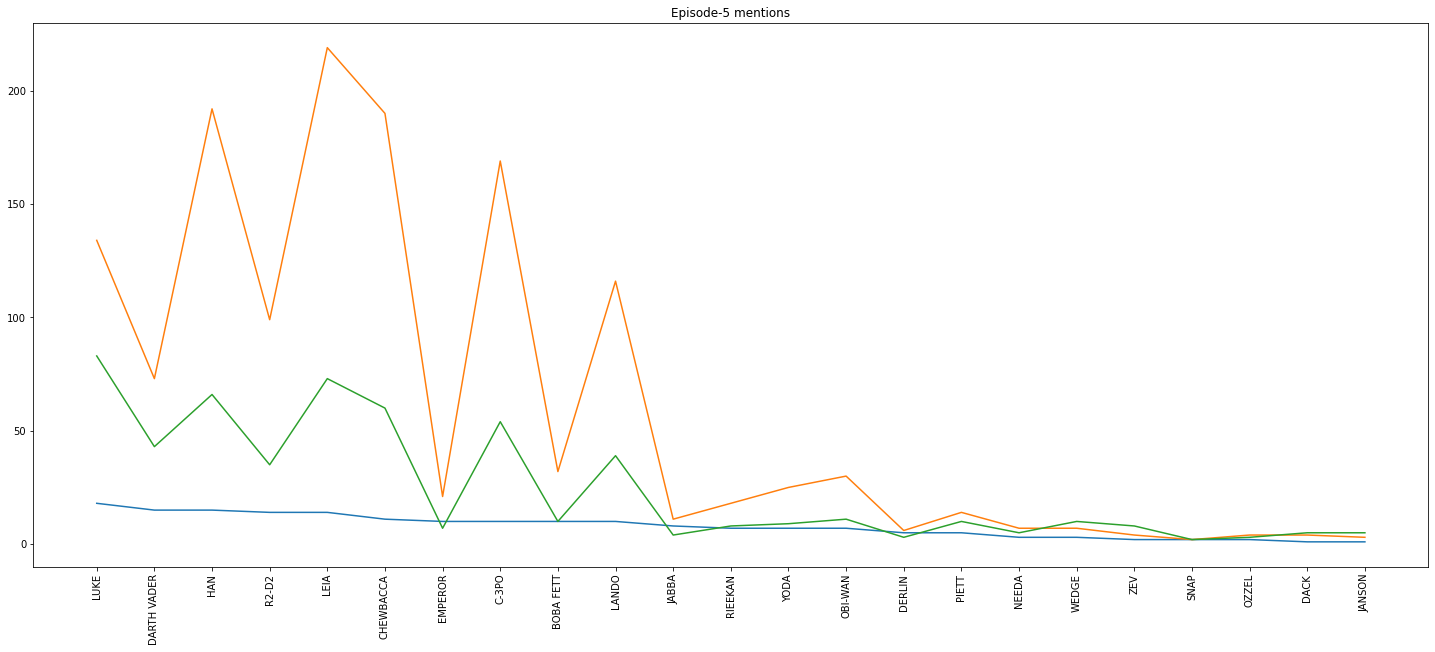

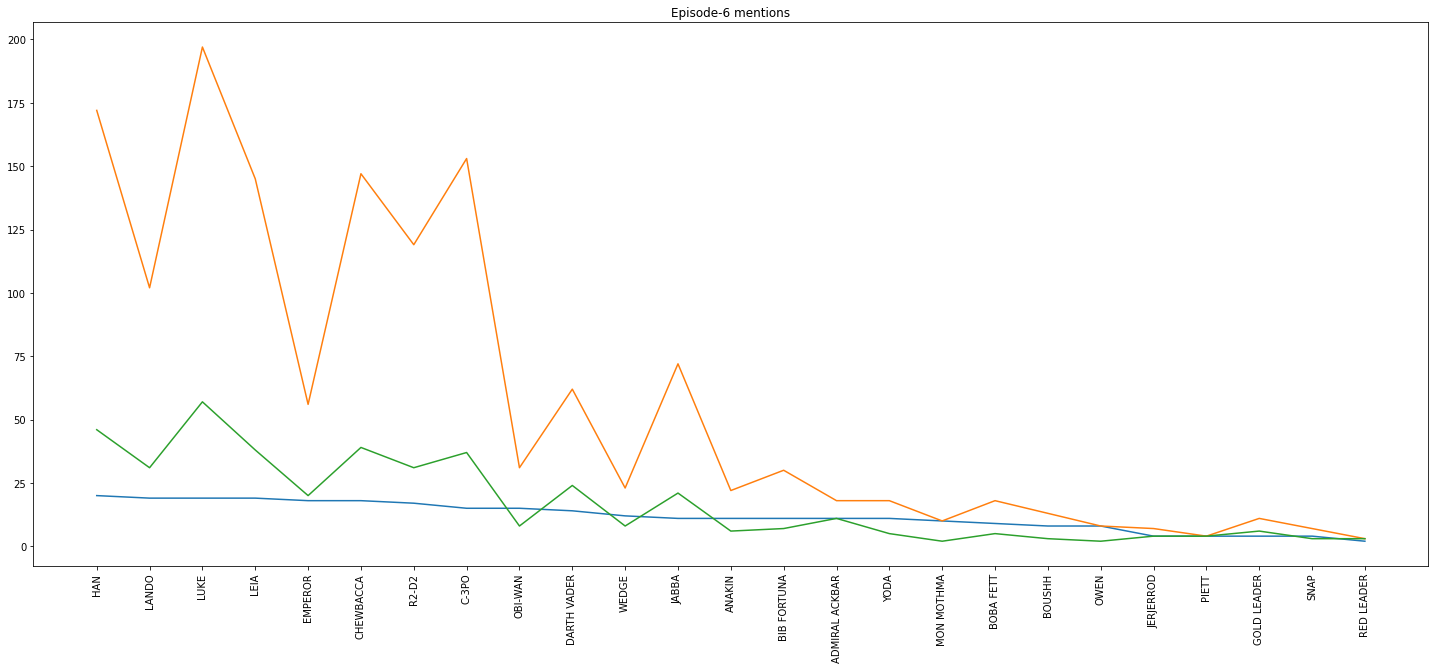

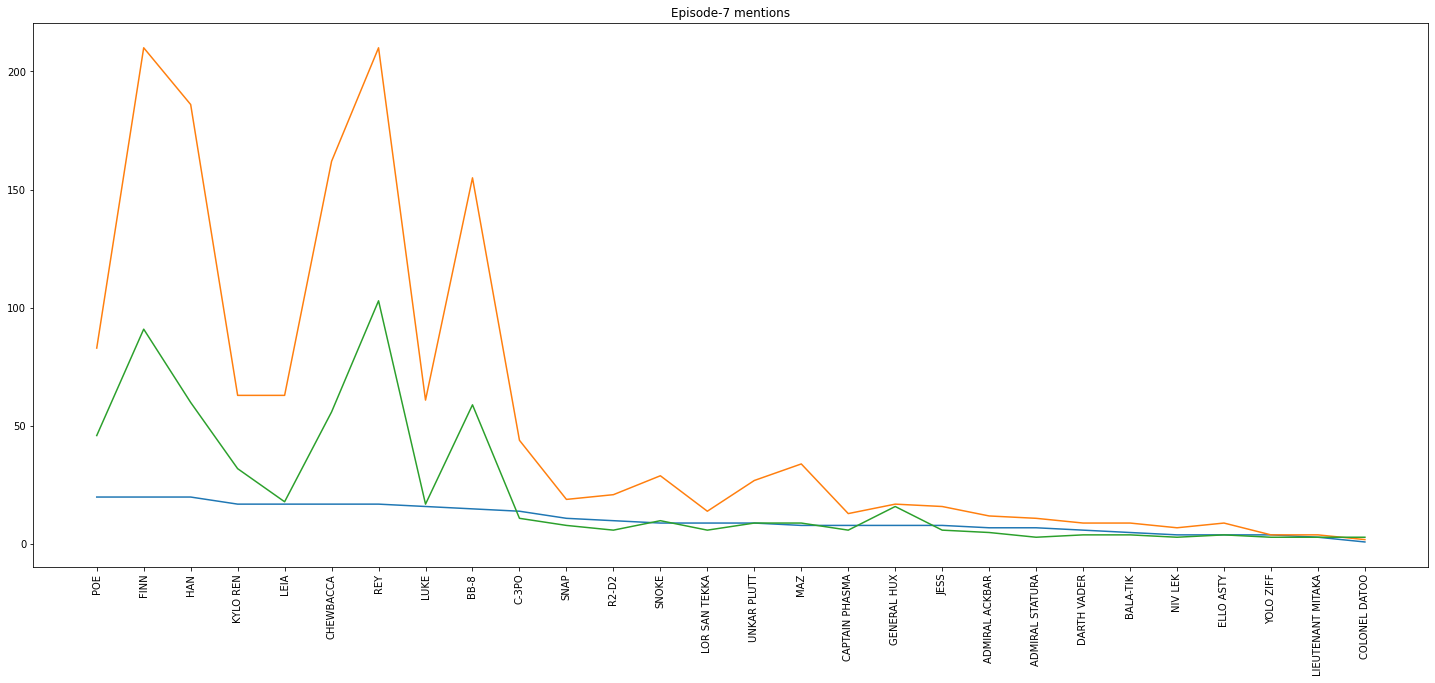

In [19]:
if __name__ == "__main__":
    features = ["interactions-allCharacters", "mentions"]
    # considering episode 0 as full series
    betweenness = []
    degree_centrality = []
    homophily = []
    classification = []
    for feature in features:
        for i in range(0,8):
            betweenness, degree_centrality, homo, classify = loop(i, feature, betweenness, degree_centrality)
            homophily.append(homo)
            classification.append(classify)


In [20]:
betweenness

[[('OBI-WAN', 0.20527616510286287),
  ('C-3PO', 0.16810394625192118),
  ('ANAKIN', 0.158361912998823),
  ('LUKE', 0.14168316245036236),
  ('HAN', 0.09639612279428685)],
 [('QUI-GON', 0.3226135226135226),
  ('ANAKIN', 0.16988362821696157),
  ('JAR JAR', 0.14583615000281666),
  ('NUTE GUNRAY', 0.1254313837647171),
  ('PADME', 0.10342138675472008)],
 [('ANAKIN', 0.3833822091886608),
  ('OBI-WAN', 0.31480109272447976),
  ('PADME', 0.1789467253176931),
  ('KI-ADI-MUNDI', 0.0625),
  ('JAR JAR', 0.06213037634408606)],
 [('OBI-WAN', 0.18631815044858524),
  ('ANAKIN', 0.1847481021394065),
  ('EMPEROR', 0.18323844030365768),
  ('BAIL ORGANA', 0.1818754313319531),
  ('YODA', 0.11592477570738441)],
 [('LUKE', 0.3223922902494331),
  ('LEIA', 0.2304988662131519),
  ('HAN', 0.1761904761904762),
  ('BIGGS', 0.041666666666666664),
  ('C-3PO', 0.04064625850340136)],
 [('LUKE', 0.41621781727044893),
  ('DARTH VADER', 0.3246753246753247),
  ('HAN', 0.11175894281157435),
  ('WEDGE', 0.09999999999999999),
 

In [21]:
degree_centrality

[[('ANAKIN', 42), ('OBI-WAN', 37), ('C-3PO', 36), ('PADME', 34), ('LUKE', 27)],
 [('QUI-GON', 26),
  ('ANAKIN', 23),
  ('JAR JAR', 18),
  ('PADME', 18),
  ('OBI-WAN', 13)],
 [('ANAKIN', 21),
  ('OBI-WAN', 18),
  ('PADME', 17),
  ('COUNT DOOKU', 10),
  ('JAR JAR', 10)],
 [('ANAKIN', 14),
  ('OBI-WAN', 13),
  ('BAIL ORGANA', 12),
  ('EMPEROR', 11),
  ('PADME', 10)],
 [('LUKE', 15), ('LEIA', 12), ('C-3PO', 10), ('R2-D2', 9), ('HAN', 8)],
 [('LUKE', 12), ('DARTH VADER', 11), ('HAN', 11), ('LEIA', 10), ('C-3PO', 10)],
 [('LUKE', 15), ('C-3PO', 11), ('LEIA', 9), ('HAN', 9), ('LANDO', 9)],
 [('POE', 16), ('HAN', 14), ('FINN', 14), ('BB-8', 12), ('CHEWBACCA', 12)]]

In [22]:
homophily

[[[('OBI-WAN', 261),
   ('LUKE', 241),
   ('PADME', 173),
   ('FINN', 113),
   ('ANAKIN', 97),
   ('R2-D2', 91),
   ('YODA', 82),
   ('HAN', 76),
   ('CHEWBACCA', 58),
   ('C-3PO', 52)],
  [('EMPEROR', 84),
   ('DARTH VADER', 52),
   ('NUTE GUNRAY', 34),
   ('ANAKIN', 16),
   ('PIETT', 12),
   ('GENERAL HUX', 11),
   ('RUNE', 11),
   ('LUKE', 10),
   ('TARKIN', 7),
   ('OBI-WAN', 7)]],
 [[('PADME', 81),
   ('OBI-WAN', 65),
   ('QUI-GON', 44),
   ('ANAKIN', 24),
   ('JAR JAR', 21),
   ('YODA', 16),
   ('CAPTAIN PANAKA', 14),
   ('R2-D2', 11),
   ('MACE WINDU', 6),
   ('SHMI', 6)],
  [('NUTE GUNRAY', 24),
   ('EMPEROR', 23),
   ('RUNE', 11),
   ('DARTH MAUL', 6),
   ('SIO BIBBLE', 3),
   ('CAPTAIN PANAKA', 3),
   ('PADME', 2),
   ('GENERAL CEEL', 2),
   ('JAR JAR', 2),
   ('VALORUM', 2)]],
 [[('OBI-WAN', 51),
   ('PADME', 50),
   ('ANAKIN', 30),
   ('YODA', 24),
   ('MACE WINDU', 14),
   ('COUNT DOOKU', 7),
   ('R2-D2', 7),
   ('LAMA SU', 6),
   ('C-3PO', 5),
   ('TAUN WE', 5)],
  [('EMP

In [23]:
classification

[(73, 7),
 (23, 3),
 (23, 0),
 (18, 1),
 (17, 0),
 (15, 1),
 (14, 1),
 (20, 3),
 (72, 9),
 (23, 3),
 (19, 6),
 (19, 9),
 (18, 2),
 (16, 2),
 (15, 4),
 (21, 2)]